In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt

import pickle
import json
import sys
sys.path.append("../../../")


from src.dataset_manager import DatasetConvertor 
from src.context_free.config import ModelConfig, TrainingConfig, MetaConfig
from src.context_free.preprocessing import PreprocessingDataset
from src.context_free.models import createModel
from src.context_free.training import trainModel
from src.context_free.evaluation import evaluateModel

In [2]:
rawDatasetFolder = "../../../data/raw"
dpdrDatasetFolder = "../../../data/processed/dpdr"
configPath = "../../config/combined_flows_forward_30.json"
modelFolder = "../../../data/models/context_free"
verbose = True

In [3]:
datasetConverter = DatasetConvertor(rawDatasetFolder, randomFlag=False)
with open(configPath, "r") as f:
    config = json.load(f)

name = config.get("NAME")
len_window = config.get("LEN_WINDOW")
dim_data = len(config.get("CONTEXT_IDXS"))
train_ratio = config.get("TRAIN_RATIO")

# =============== Preprocessing ===============
datasetConverter.addDataUnit(config)
dataUnit = datasetConverter.getDataUnit(name)
max_vals, min_vals = dataUnit.getMaxMinMbnVals()
metaConfig = MetaConfig.initialize(
    dim_data=dim_data, 
    len_window=len_window
)

trainDataUnit, testDataUnit = dataUnit.split(train_ratio)
dataProcessor = PreprocessingDataset(metaConfig)
trainData = dataProcessor.process(trainDataUnit, dataAugment=True)
testData = dataProcessor.process(testDataUnit, dataAugment=False)

In [4]:
# Match model dims to dataset feature sizes
modelConfig = ModelConfig()
model, device = createModel(modelConfig)

# Reduce training load to avoid OOM/errors
trainingConfig = TrainingConfig()
model, avg_train_loss_history, avg_test_loss_history = trainModel(
    model, trainData, testData, trainingConfig, verbose=verbose
)
model.save_checkpoint(f"{modelFolder}/{name}.pth")
with open(f"{modelFolder}/{name}_modelConfig.pkl", "wb") as f:
    pickle.dump(modelConfig, f)
with open(f"{modelFolder}/{name}_metaConfig.pkl", "wb") as f:
    pickle.dump(metaConfig, f)


Size of train loader: 3, Size of test loader: 1
Size of model: 1324289
Seq2Seq(
  (encoder): Encoder(
    (lstm_layers): ModuleList(
      (0): LSTM(1, 128, bidirectional=True)
      (1): LSTM(256, 128, bidirectional=True)
    )
    (ln_layers): ModuleList(
      (0-1): 2 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (residual_projections): ModuleList(
      (0): Linear(in_features=1, out_features=256, bias=True)
      (1): Identity()
    )
  )
  (decoder): Decoder(
    (lstm_layers): ModuleList(
      (0): LSTM(1, 256)
      (1): LSTM(256, 256)
    )
    (ln_layers): ModuleList(
      (0-1): 2 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (residual_projections): ModuleList(
      (0): Linear(in_features=1, out_features=256, bias=True)
      (1): Identity()
    )
    (fc_out): Linear(in_features=256, out_features=1, bias=True)
  )
)
Epoch [1/50], Train Loss: 45.319437, Validation Loss: 11.545962
Epoch [2/50], Train Loss: 15.995558, Validation Los

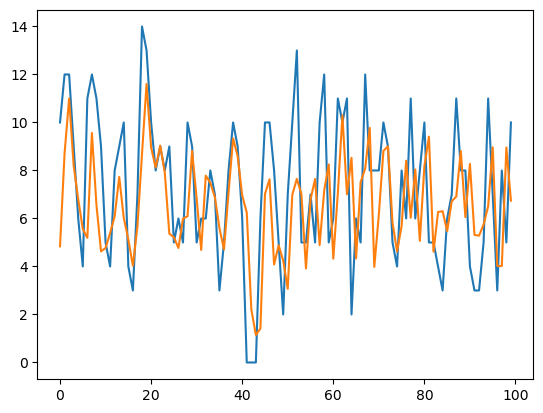

In [7]:
with open(f"{modelFolder}/{name}_modelConfig.pkl", "rb") as f:
    modelConfig = pickle.load(f)
model, device = createModel(modelConfig)
model.load_checkpoint(f"{modelFolder}/{name}.pth")
actual, predicted = evaluateModel(model, testData)

plt.plot(actual[0:100])
plt.plot(predicted[0:100])
plt.show()